# ResNet


In this problem, you are asked to train a deep convolutional neural network to perform image classification. In this mini-project you are tasked with coming up with a modified residual network (ResNet) architecture with the highest test accuracy on the CIFAR10 image classification dataset, under the constraint that your model has no more than 5 million parameters.

We will train ResNet using the CIFAR10 dataset, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torchsummary import summary

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn

import copy
import random
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
cudnn.deterministic = True

# Loading and Preparing the Data
Our dataset is made up of color images but three color channels (red, green and blue), compared to MNIST's black and white images with a single color channel. To normalize our data we need to calculate the means and standard deviations for each of the color channels independently, and normalize them.

In [ ]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


In [ ]:
# Compute means and standard deviations along the R,G,B channel

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [ ]:
means

array([0.49139968, 0.48215841, 0.44653091])

In [ ]:
stds = (0.2023, 0.1994, 0.2010)
stds

(0.2023, 0.1994, 0.201)

Next, we will do data augmentation. For each training image we will randomly rotate it (by up to 5 degrees), flip/mirror with probability 0.5, shift by +/-1 pixel. Finally we will normalize each color channel using the means and stds we initialized above.

In [ ]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])


Next, we'll load the dataset along with the transforms defined above.

We will also create a validation set with 10% of the training samples. The validation set will be used to monitor loss along different epochs, and we will pick the model along the optimization path that performed the best, and report final test accuracy numbers using this model.

In [ ]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# Plotting

Now, we'll create a function to plot some of the images in our dataset to see what they actually look like.

Note that by default PyTorch handles images that are arranged [channel, height, width], but matplotlib expects images to be [height, width, channel], hence we need to permute the dimensions of our images before plotting them.

In [ ]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

One point here: matplotlib is expecting the values of every pixel to be between  [0,1] , however our normalization will cause them to be outside this range. By default matplotlib will then clip these values into the  [0,1]  range. This clipping causes all of the images to look a bit weird - all of the colors are oversaturated. The solution is to normalize each image between [0,1].

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

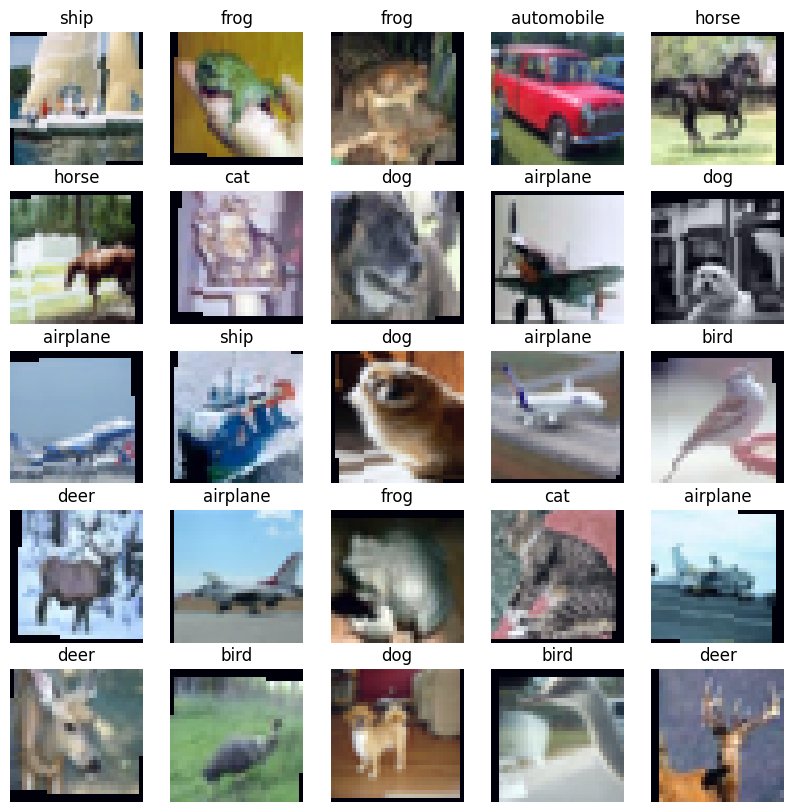

In [ ]:
plot_images(images, labels, classes, normalize = True)

The final bit of the data processing is creating the iterators. We will use a large. Generally, a larger batch size means that our model trains faster but is a bit more susceptible to overfitting.

In [ ]:
BATCH_SIZE = 128

train_iterator = torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False, 
                                          num_workers=1)

# Defining the Model

We define the ResNet model here. Also, we shall display the model architecture and number of paramters using torchsummary.summary function.



In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(32, 32, 32, 3, stride=1)
        self.layer2 = self.make_layer(32, 64, 64, 3, stride=2)
        self.layer3 = self.make_layer(64, 128, 128, 3, stride=2)
        self.layer4 = self.make_layer(128, 256, 256, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def make_layer(self, in_channels, mid_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, mid_channels, out_channels, stride=stride))
        for i in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels, mid_channels, out_channels))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        identity = self.downsample(identity)
        
        out += identity
        out = self.relu(out)
        
        return out


Now, we instantiate the model

In [ ]:
model = ResNet()

# Training the Model

We first initialize parameters in PyTorch by creating a function that takes in a PyTorch module, checking what type of module it is, and then using the nn.init methods to actually initialize the parameters.

We shall use He Normal initialization for the convolutional layers and Xavier Normal initialization for the fully connected layer. We shall also initialize the batch normalization layers with a scale factor of 1 and a bias term of 0.

We then define the loss function we want to use, the device we'll use and place our model and criterion on to our device.

In [ ]:
lr = 0.1
optimizer = optim.Adam(model.parameters(), lr = lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    model = nn.DataParallel(model)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=15)

model = model.to(device)
criterion = criterion.to(device)

summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
          Identity-9           [-1, 32, 32, 32]               0
             ReLU-10           [-1, 32, 32, 32]               0
    ResidualBlock-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

We define a function to calculate accuracy...

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

As we are using dropout we need to make sure to "turn it on" when training by using model.train()

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We also define an evaluation loop, making sure to "turn off" dropout with model.eval().

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


Next, we define a function to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, finally, we train our model.

Train it for 50 epochs (using the train dataset). At the end of each epoch, compute the validation loss and keep track of the best model. You might find the command torch.save helpful.

In [ ]:
N_EPOCHS = 100
best_valid_loss = float('inf')
lrs = []
train_loss_list,valid_loss_list  = [], []
train_acc_list, valid_acc_list = [], []
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Learning Rate {lrs[-1]:.3f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


Epoch: 01 | Epoch Time: 0m 37s
Learning Rate 0.100
	Train Loss: 2.053 | Train Acc: 27.01%
	 Val. Loss: 1.772 |  Val. Acc: 32.03%
Epoch: 02 | Epoch Time: 0m 35s
Learning Rate 0.100
	Train Loss: 1.525 | Train Acc: 43.26%
	 Val. Loss: 1.457 |  Val. Acc: 47.15%
Epoch: 03 | Epoch Time: 0m 34s
Learning Rate 0.100
	Train Loss: 1.285 | Train Acc: 53.07%
	 Val. Loss: 1.211 |  Val. Acc: 58.44%
Epoch: 04 | Epoch Time: 0m 34s
Learning Rate 0.100
	Train Loss: 1.094 | Train Acc: 60.69%
	 Val. Loss: 1.025 |  Val. Acc: 63.48%
Epoch: 05 | Epoch Time: 0m 35s
Learning Rate 0.100
	Train Loss: 0.967 | Train Acc: 65.56%
	 Val. Loss: 0.922 |  Val. Acc: 67.05%
Epoch: 06 | Epoch Time: 0m 34s
Learning Rate 0.100
	Train Loss: 0.863 | Train Acc: 69.70%
	 Val. Loss: 0.877 |  Val. Acc: 69.49%
Epoch: 07 | Epoch Time: 0m 35s
Learning Rate 0.100
	Train Loss: 0.782 | Train Acc: 72.75%
	 Val. Loss: 0.886 |  Val. Acc: 69.90%
Epoch: 08 | Epoch Time: 0m 35s
Learning Rate 0.100
	Train Loss: 0.725 | Train Acc: 74.90%
	 Val. 

# Evaluating the model

We then load the parameters of our model that achieved the best validation loss.



In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.389 | Test Acc: 90.46%


Printing the confusion matrix

In [ ]:
def get_predictions(model, iterator, device):
    model.eval()
    labels = []
    probs = []
    with torch.no_grad():
      for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            labels.append(y)
            probs.append(torch.softmax(y_pred, dim=1))
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [ ]:
labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    labels = labels.cpu().numpy()
    pred_labels = pred_labels.cpu().numpy()

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.show()

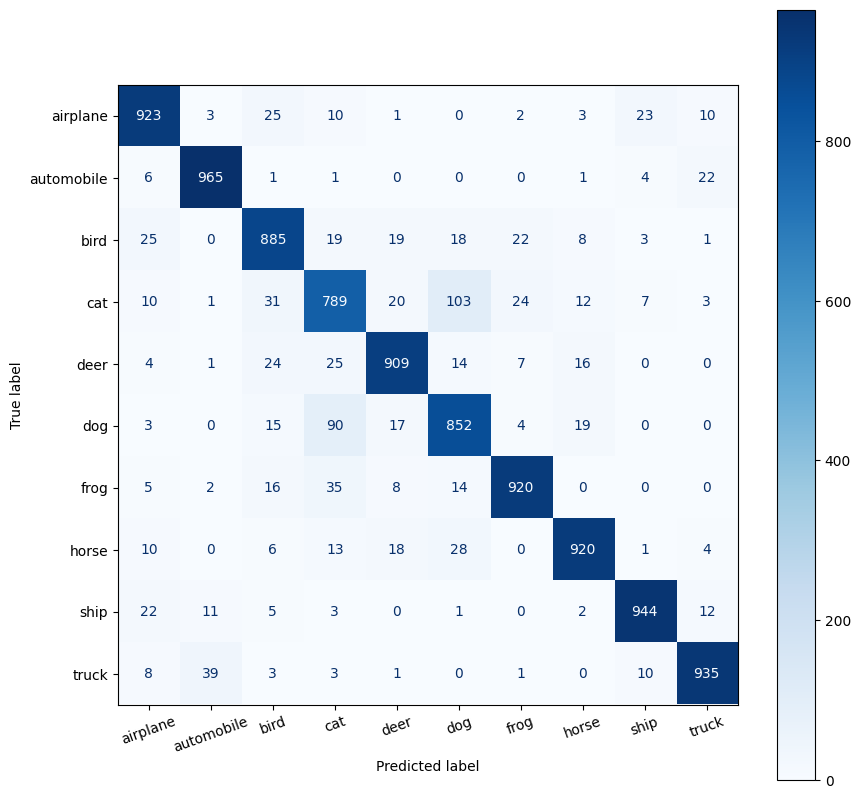

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes) 

# Comments

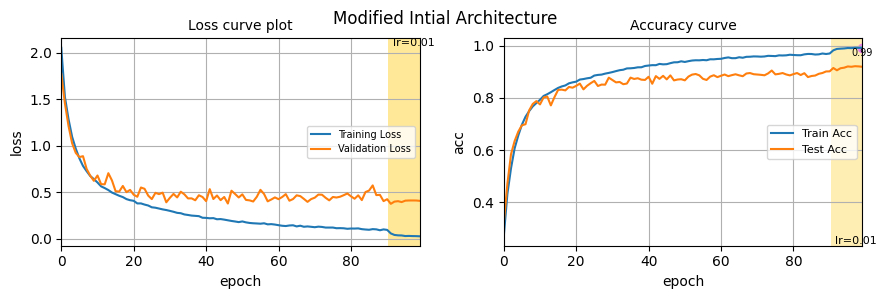

In [ ]:
import numpy as np
xax = range(N_EPOCHS)

# Loss Curve
fig, axs = plt.subplots(1, 2, figsize=(9,3))
axs[0].plot(xax, train_loss_list, label="Training Loss")
axs[0].plot(xax, valid_loss_list, label="Validation Loss")
axs[0].set_title('Loss curve plot', fontsize=10)

axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].grid()
axs[0].legend(loc="center right", fontsize=7)
axs[0].pcolorfast(xax, axs[0].get_ylim(), np.log(np.array(lrs))[np.newaxis], cmap="hot", alpha=0.4, vmax=np.log(1e-1), vmin=np.log(1e-4))

for j in range(1,N_EPOCHS-1):
    if lrs[j] != lrs[j-1]:
        axs[0].text(j+0.5, axs[0].get_ylim()[1]-0.0005, f"lr={round(lrs[j],6)}", fontsize=8, va="top")

# Accuracy Curve
axs[1].plot(xax, train_acc_list, label="Train Acc")
axs[1].plot(xax, valid_acc_list, label="Test Acc")
best_epoch, best_val = np.argmax(train_acc_list), max(train_acc_list)
axs[1].scatter(best_epoch, best_val, marker="o", c="violet")
axs[1].text(best_epoch, best_val, round(best_val, 2), va="top", ha="center", fontsize=7)
axs[1].set_title('Accuracy curve', fontsize=10)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('acc')
axs[1].grid()
axs[1].legend(loc="center right", fontsize=8)
axs[1].pcolorfast(xax, axs[1].get_ylim(), np.log(np.array(lrs))[np.newaxis], cmap="hot", alpha=0.3, vmax=np.log(1e-1), vmin=np.log(1e-4))

for j in range(1,N_EPOCHS-1):
    if lrs[j] != lrs[j-1]:
        axs[1].text(j+0.5, axs[1].get_ylim()[0]-0.0005, f"lr={round(lrs[j],6)}", fontsize=8, va="bottom")

fig.tight_layout()
fig.suptitle("Modified Intial Architecture")
fig.show()